## E17 - ocr

google cloud platform에서 vision api 이용하기   
서비스 계정 및 인증키가 필요하다   
http://egloos.zum.com/mcchae/v/11342622   
https://console.cloud.google.com/   
my_google_api_key.json파일로 저장하기   

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [2]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

# 입력 이미지 경로를 지정해 주세요.
import os
path = os.getenv('HOME') + '/aiffel/ocr_python/my_image.jpeg' 

# path = '/HOME/aiffel0042/aiffel/ocr_python/my_image.jpeg'  
# ex.) '~/aiffel/ocr_python/test_image.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-rw-r-- 1 aiffel0042 aiffel0042 2349 10월  7 17:47 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #661492106793 by visiting https://console.developers.google.com/billing/enable?project=661492106793 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

keras-ocr 써보기   
검출 모델은 craft 사용   
인식 모델은 CRNN 사용   
pip install keras-ocr   
keras_ocr.pipeline.Pipeline(): 인식을 위한 파이프라인을 생성함. 초기화 과정에서 미리 학습된 모델의 가중치 로드. 검출기와 인식기의 가중치   
cuDNN 관련 에러가 발생 할 수 있으므로 export TF_FORCE_GPU_ALLOW_GROWTH=true 명령 실행   
영구 적용은 echo "export TF_FORCE_GPU_ALLOW_GROWTH=true" >> ~/.bashrc   

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


In [2]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg'
    ]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

# recognize()는 검출기와 인식기를 두고, 검출기로 바운딩 박스를 검출하고 인식기로 박스로부터 문자를 인식한다.

ResourceExhaustedError:  OOM when allocating tensor with shape[512,512,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_1/basenet.slice3.27/Conv2D (defined at /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/detection.py:682) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_9793]

Function call stack:
predict_function


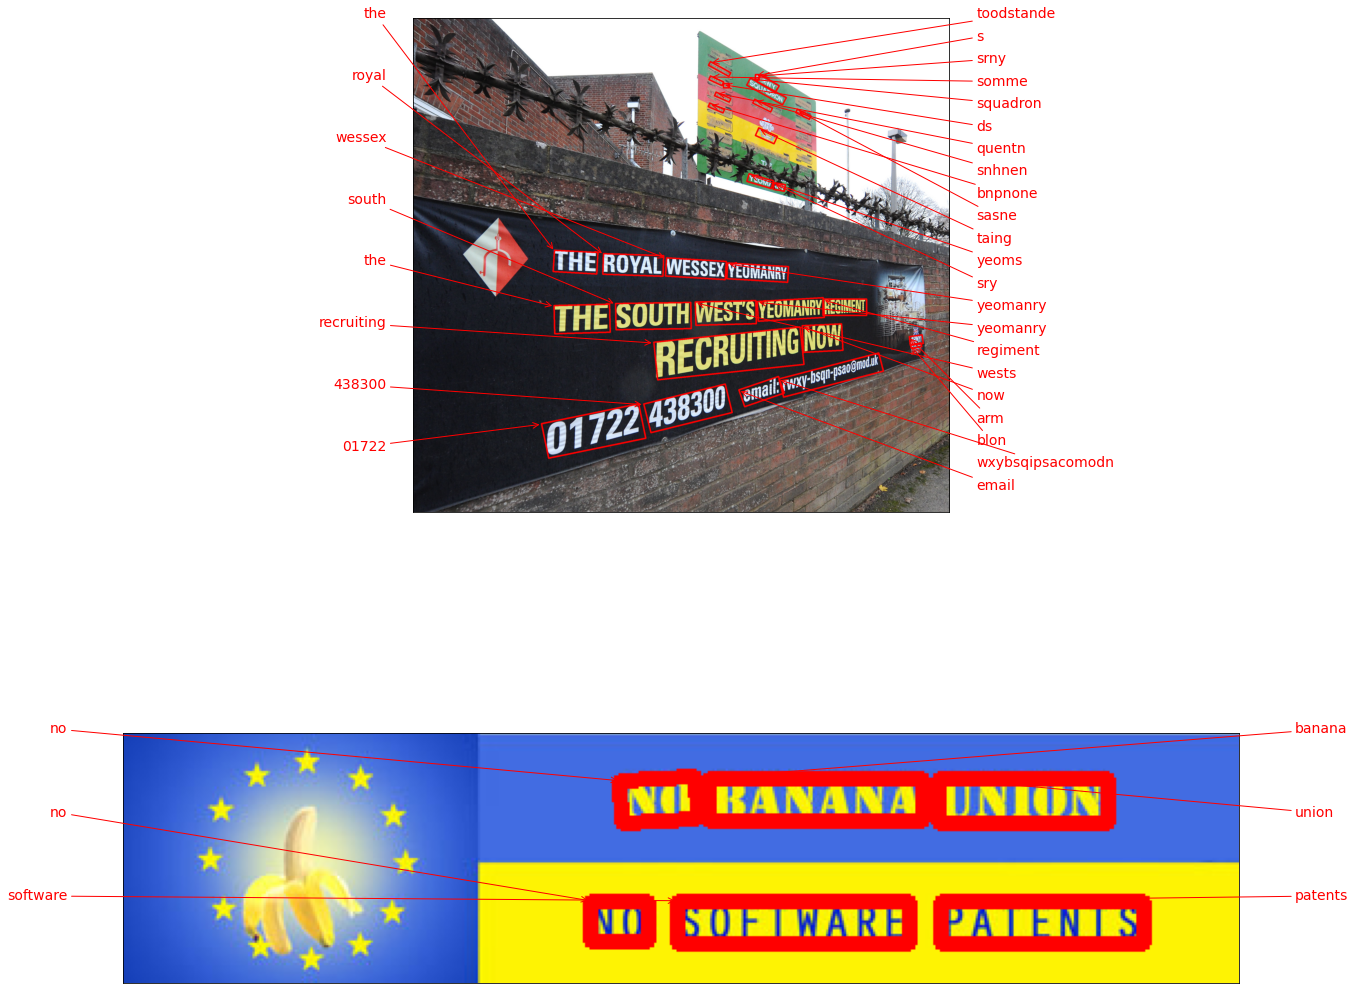

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

테서랙트 써보기   
sudo apt install tesseract-ocr   
sudo apt install libtesseract-dev   
pytesseract: 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리   
래퍼 라이브러리?: https://ko.wikipedia.org/wiki/%EB%9E%98%ED%8D%BC_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC   
pip install pytesseract   
테서랙트는 이미지 내의 문자 검출과 인식을 한 번에 수행한다.

In [ ]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor', sudo apt install tesseract-ocr-kor
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/my_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

# crop_word_regions() 함수는 입력받은 이미지에서 문잦을 검출하고 그 문자 영역을 크롭하여 이미지로 만들어 list로 반환


In [ ]:
# 테서렉트로 잘린 이미지에서 단어 인식하기
# image_to_string(): 바운딩 박스 별로 잘린 이미지를 입력하면 텍스트를 반환한다.
